In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import signal
import os
import mne
import mne_microstates

In [2]:
f = open('FinalProjectData/sub_02.json')
data = json.load(f)

In [3]:
data.keys()

dict_keys(['1_idea evolution', '1_idea generation', '1_idea rating', '1_rest', '2_idea evolution', '2_idea generation', '2_idea rating', '3_idea evolution', '3_idea generation', '3_idea rating', '3_rest'])

In [4]:
subject_dict_raw = {}
subject_dict_segments = {}

## Microstate Analysis

In [5]:
for i, file in enumerate(sorted(os.listdir('FinalProjectData'))[2:]):
    f = open('FinalProjectData/' + file)
    data = json.load(f)
    subject_dict_raw[i] = {}
    subject_dict_segments[i] = {}
    for key in list(data.keys()):
        arr = np.array(data[key])
        subject_dict_raw[i][key] = arr
        raw = mne.io.RawArray(arr, info = mne.create_info([str(i) for i in range(arr.shape[0])], 300, ch_types='eeg', verbose=0), verbose=0)
        raw.set_eeg_reference('average', verbose=0)
        raw.filter(0.2, None, verbose=0)
        raw.pick_types(meg=False, eeg=True, verbose=0)
        maps, segmentation = mne_microstates.segment(raw.get_data(), n_states=6, verbose=0)
        subject_dict_segments[i][key] = segmentation
    #     mne_microstates.plot_segmentation(segmentation[:500], raw.get_data()[:, :500], raw.times[:500])

/var/folders/0h/y5d1d7vs2lq_lbjt1p8zk7d80000gn/T/ipykernel_12441/3223368427.py:11: RuntimeWarning: filter_length (4951) is longer than the signal (4000), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.2, None, verbose=0)
/var/folders/0h/y5d1d7vs2lq_lbjt1p8zk7d80000gn/T/ipykernel_12441/3223368427.py:11: RuntimeWarning: filter_length (4951) is longer than the signal (4000), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.2, None, verbose=0)
/var/folders/0h/y5d1d7vs2lq_lbjt1p8zk7d80000gn/T/ipykernel_12441/3223368427.py:11: RuntimeWarning: filter_length (4951) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.2, None, verbose=0)
/var/folders/0h/y5d1d7vs2lq_lbjt1p8zk7d80000gn/T/ipykernel_12441/3223368427.py:11: RuntimeWarning: filter_length (4951) is longer than the signal (3000), distortion is likely. Reduce filter length or filter a longer signal.

In [6]:
microstate_rel_frequency = np.zeros((28, 4, 6, 1))

for subject in list(subject_dict_segments.keys()):
    for key in subject_dict_segments[subject].keys():
        if 'rest' in key:
            i=0
        elif 'idea generation' in key:
            i=1
        elif 'evolution' in key:
            i=2
        else:
            i=3
        arr = subject_dict_segments[subject][key]
        
        for n in np.unique(arr):
            if microstate_rel_frequency[subject][i][n] == 0: 
                microstate_rel_frequency[subject][i][n] = (arr == n).sum()/len(arr)
            else:
                microstate_rel_frequency[subject][i][n] += (arr == n).sum()/len(arr)

In [7]:
mean_over_all_subjects = np.average(microstate_rel_frequency, axis=0)

In [8]:
mean_over_all_subjects[1:, :] = mean_over_all_subjects[1:, :]/3 
mean_over_all_subjects[0, :] = mean_over_all_subjects[0, :]/2

In [9]:
keys = ['Rest', 'Idea Generation', 'Idea Evolution', 'Evaluation']

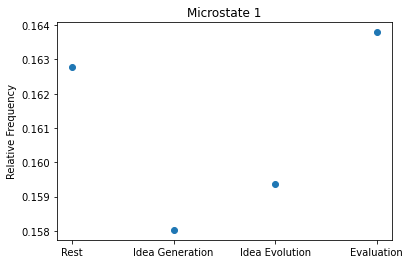

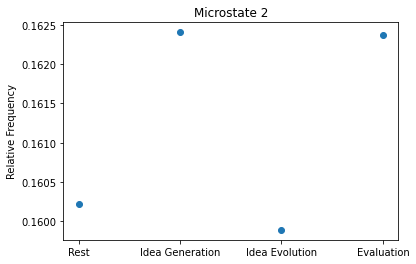

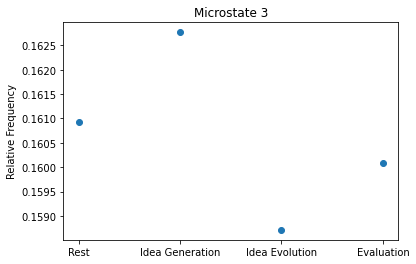

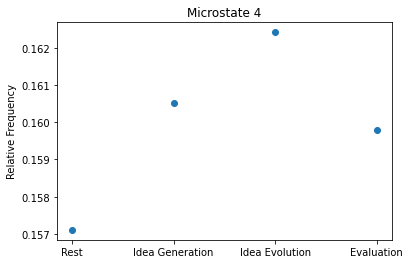

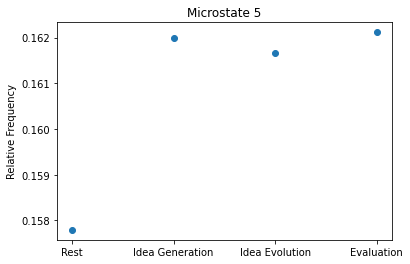

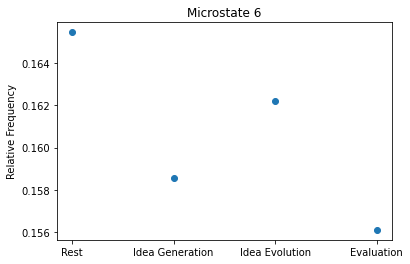

In [11]:
for ms in range(6):
    plt.scatter(keys, mean_over_all_subjects[:, ms])
    plt.title(f"Microstate {ms+1}")
    plt.ylabel('Relative Frequency')
    plt.show()
    # plt.savefig('Microstate_' + str(ms+1) + '.png')


Creating RawArray with float64 data, n_channels=63, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    49.997 secs
Ready.


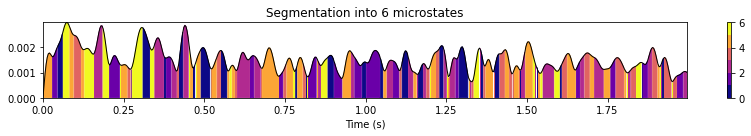

In [12]:
arr = subject_dict_raw[0]['1_idea evolution']
raw = mne.io.RawArray(arr, info = mne.create_info([str(i) for i in range(arr.shape[0])], 300, ch_types='eeg', verbose=None))
maps, segmentation = mne_microstates.segment(raw.get_data(), n_states=6, verbose=0)
mne_microstates.plot_segmentation(segmentation[:600],raw.get_data()[:, :600], raw.times[:600])

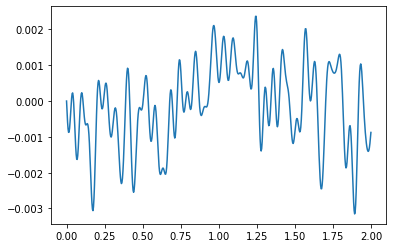

In [37]:
plt.plot(raw.times[:600], raw.get_data()[1, :600] )

In [13]:
X = microstate_rel_frequency.reshape((112,6))
y = keys * 28

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=265)

In [15]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

svm = SVC(C=.20)
svm = MLPClassifier((20, 50, 65, 20,), max_iter=1000, verbose=False)
svm.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(20, 50, 65, 20), max_iter=1000)

In [16]:
preds = svm.predict(X_test)
accuracy = (preds==y_test).sum()/len(preds)
accuracy

0.5

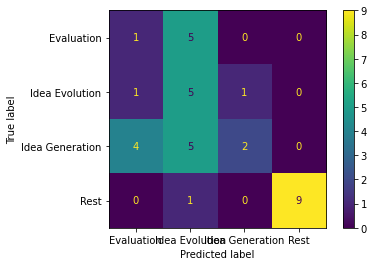

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm.classes_)
disp.plot()
plt.savefig('confusion_matrix_just_microstate.png')

## Frequency Domain Analysis

In [18]:
from scipy.fft import fft, fftfreq
import seaborn as sns

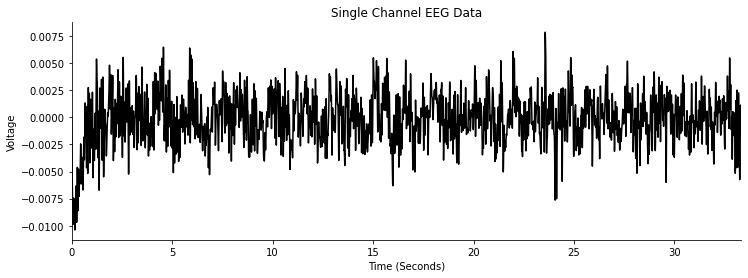

In [19]:
sig = subject_dict_raw[0]['1_idea generation'][0]
sampling_frequency = 300
time = np.arange(sig.size) / sampling_frequency

fig, ax = plt.subplots(1, 1, figsize=(12,4))
plt.plot(time, sig, lw=1.5, color='k')
plt.xlabel('Time (Seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('Single Channel EEG Data')
sns.despine()
# plt.plot([i for i in range(sig[0].size)], sig[0], color='k')

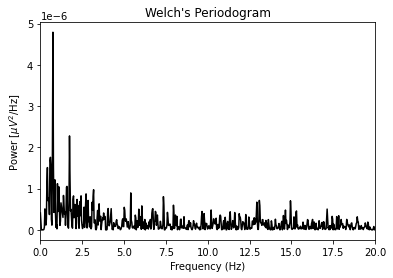

In [20]:
from scipy import signal
size = len(sig)
fs = 300

F, PSD = signal.welch(sig, fs, nperseg=size)
plt.plot(F,PSD, color='k')
plt.title("Welch's Periodogram")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power [$\mu V^2$/Hz]')
# plt.ylim([0,40])
plt.xlim([0,20])
plt.show()

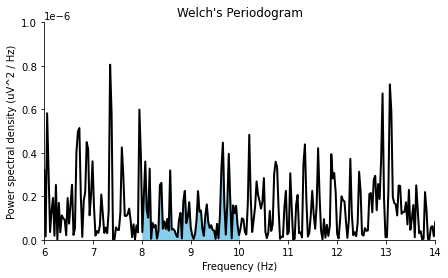

In [26]:
import seaborn as sns
low, high = 8, 10

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(F >= low, F <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(F, PSD, lw=2, color='k')
plt.fill_between(F, PSD, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([6, 14])
# plt.ylim([0, PSD.max() * 1.1])
plt.ylim([0,.1e-5])
plt.title("Welch's Periodogram")
sns.despine()

In [27]:
from scipy.integrate import simps

# Frequency resolution
freq_res = F[1] - F[0]

# Compute the absolute power by approximating the area under the curve
alpha_power = simps(PSD[idx_alpha], dx=freq_res)
print('Absolute lower alpha power: %.10f uV^2' % alpha_power)

Absolute lower alpha power: 0.0000002293 uV^2


In [28]:
subject_dict_raw[0]['1_idea evolution'].shape

(63, 15000)

In [29]:
trp_alpha = np.zeros((28, 4, 2, 1))

for subject in list(subject_dict_raw.keys()):
    curr_subject = subject_dict_raw[subject]
    for key in list(curr_subject.keys()):
        if 'rest' in key:
            i=0
        elif 'idea generation' in key:
            i=1
        elif 'evolution' in key:
            i=2
        else:
            i=3
        sig = curr_subject[key]
        sig = np.mean(arr, axis=0)
        size = len(sig)
        fs = 300
        F, PSD = signal.welch(sig, fs, nperseg=size)
        
        low, high = 8, 10
        # Find intersecting values in frequency vector
        idx_lower_alpha = np.logical_and(F >= low, F <= high)
        req_res = F[1] - F[0]
        lower_alpha_power = simps(PSD[idx_lower_alpha], dx=freq_res)
        trp_alpha[subject][i][0] = lower_alpha_power
        
        low, high = 10, 12
        # Find intersecting values in frequency vector
        idx_upper_alpha = np.logical_and(F >= low, F <= high)
        req_res = F[1] - F[0]
        upper_alpha_power = simps(PSD[idx_upper_alpha], dx=freq_res)        
        trp_alpha[subject][i][1] = upper_alpha_power 

In [30]:
trp_alpha_all_channels = np.zeros((28, 63, 4, 2, 1))

for subject in list(subject_dict_raw.keys()):
    curr_subject = subject_dict_raw[subject]
    for key in list(curr_subject.keys()):
        if 'rest' in key:
            i=0
        elif 'idea generation' in key:
            i=1
        elif 'evolution' in key:
            i=2
        else:
            i=3
        sig = curr_subject[key]
#         sig = np.mean(arr, axis=0)
        for channel in range(sig.shape[0]):
            curr = sig[channel]
            size = len(curr)
            fs = 300
            F, PSD = signal.welch(curr, fs, nperseg=size)

            low, high = 8, 10
            # Find intersecting values in frequency vector
            idx_lower_alpha = np.logical_and(F >= low, F <= high)
            req_res = F[1] - F[0]
            lower_alpha_power = simps(PSD[idx_lower_alpha], dx=freq_res)
            trp_alpha_all_channels[subject][channel][i][0] = lower_alpha_power

            low, high = 10, 12
            # Find intersecting values in frequency vector
            idx_upper_alpha = np.logical_and(F >= low, F <= high)
            req_res = F[1] - F[0]
            upper_alpha_power = simps(PSD[idx_upper_alpha], dx=freq_res)        
            trp_alpha_all_channels[subject][channel][i][1] = upper_alpha_power 

In [31]:
across_subject_alpha = np.average(trp_alpha, axis=0)
across_subject_alpha.shape

(4, 2, 1)

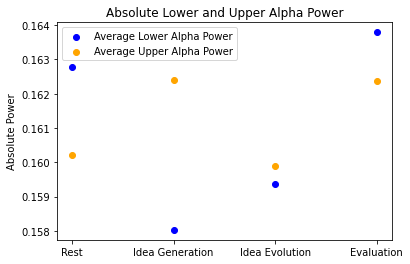

In [38]:
plt.title('Absolute Lower and Upper Alpha Power')
plt.ylabel('Absolute Power')
plt.scatter(keys, mean_over_all_subjects[:, 0], color='blue', label='Average Lower Alpha Power')
plt.scatter(keys, mean_over_all_subjects[:, 1], color='orange', label="Average Upper Alpha Power")
plt.legend()
plt.savefig('alpha_power.png')

In [39]:
trp_alpha.shape

(28, 4, 2, 1)

In [40]:
microstate_rel_frequency.shape

(28, 4, 6, 1)

In [41]:
microstate_and_alpha = np.append(microstate_rel_frequency, trp_alpha, axis=2).reshape(28,4,8,1)

In [42]:
X = microstate_and_alpha.reshape((112,8))
y = keys * 28
y = np.array(y)

In [43]:
X.shape

(112, 8)

In [44]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [59]:
from tensorflow.keras.utils import to_categorical

numeric_labels = []
for lab in y:
    if 'Evolution' in lab:
        numeric_labels.append(0)
    elif 'Generation' in lab:
        numeric_labels.append(1)
    elif 'Evaluation' in lab:
        numeric_labels.append(2)
    else:
        numeric_labels.append(3)
        
y = to_categorical(numeric_labels)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=265)

In [65]:
import tensorflow.keras as keras
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='tanh', input_shape=(8,)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(128, activation='tanh'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256, activation='tanh'))
model.add(keras.layers.Dense(4, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['accuracy'])

In [66]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, y_train, epochs = 1000, batch_size=10, validation_data=(X_test, y_test), callbacks=[callback, model_checkpoint_callback])

Epoch 1/1000
7/8 [=========================>....] - ETA: 0s - loss: 1.2485 - accuracy: 0.4143

2022-04-17 21:50:22.295454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 32ms/step - loss: 1.2490 - accuracy: 0.4103 - val_loss: 1.2464 - val_accuracy: 0.4412
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 1.1899 - accuracy: 0.4231

2022-04-17 21:50:22.521363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 16ms/step - loss: 1.1899 - accuracy: 0.4231 - val_loss: 1.1961 - val_accuracy: 0.4706
Epoch 3/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.1255 - accuracy: 0.4744 - val_loss: 1.1559 - val_accuracy: 0.4706
Epoch 4/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.1362 - accuracy: 0.5000 - val_loss: 1.1202 - val_accuracy: 0.5000
Epoch 5/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.1168 - accuracy: 0.4615 - val_loss: 1.0923 - val_accuracy: 0.5000
Epoch 6/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.0472 - accuracy: 0.5385 - val_loss: 1.0697 - val_accuracy: 0.5000
Epoch 7/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.0691 - accuracy: 0.5513 - val_loss: 1.0489 - val_accuracy: 0.5000
Epoch 8/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.9979 - accuracy: 0.5897 - val_loss: 1.0347 - val_accuracy: 0.4706
Epoch 9/1000
8/8 [========

In [67]:
loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = model.evaluate(X_test, y_test)
test_loss

2/2 [==============================] - 0s 15ms/step - loss: 0.8854 - accuracy: 0.5294


[0.8854491710662842, 0.529411792755127]

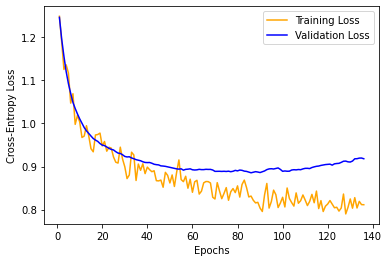

In [68]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'orange', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.savefig('network_loss_history')

In [69]:
from sklearn.svm import SVC
y = keys * 28
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=265)

lr = SVC(C=100, max_iter=10000, kernel="poly", degree=2, random_state=11)
lr.fit(X_train, y_train)

SVC(C=100, degree=2, kernel='poly', max_iter=10000, random_state=11)

In [70]:
preds = lr.predict(X_test)
accuracy = (preds==y_test).sum()/len(preds)
accuracy

0.5588235294117647

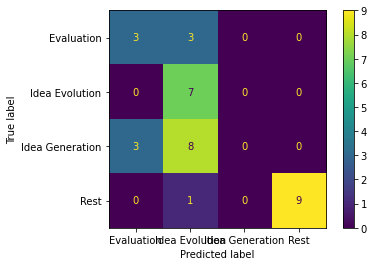

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm.classes_)
disp.plot()
plt.show()

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=265)
pca_results = pca.fit_transform(X_scaled)

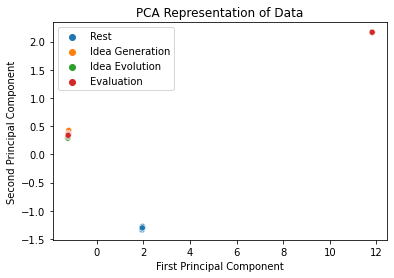

In [55]:
sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1], hue=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Representation of Data')
plt.savefig('pca_scatter.png')

In [56]:
from mlxtend.plotting import plot_decision_regions
svm_pca = SVC(C=100, random_state=265, kernel='poly', degree=4)
svm_pca.fit(pca_results, y)
plot_decision_regions(np.array(pca_results), y, axis=1, clf=svm_pca, legend=3)
plt.title('SVM Polynomial Kernel Decision Boundary')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.savefig('SVM_decision_boundary.png')

TypeError: plot_decision_regions() got an unexpected keyword argument 'axis'

## Time-Frequency Domain Analysis

In [71]:
import cv2

def generate_spectrogram(data, sampling_frequency=300):
    data = np.mean(data, axis=0)
    f, t, Sxx = signal.spectrogram(
        data,
        fs=sampling_frequency,
        nperseg=sampling_frequency,
        noverlap=sampling_frequency*0.95,)    
    plt.ylim([0,20])
    plt.axis('off')
    plt.pcolormesh(t, f, Sxx, cmap='viridis')
    plt.savefig('temp', bbox_inches='tight', pad_inches=0)
    img = cv2.imread('temp.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, img.shape

KeyboardInterrupt: 

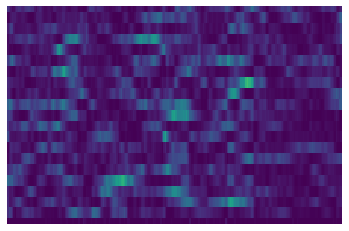

In [207]:
labels = []
spectrograms = []
subjects = []

for subject in list(subject_dict_raw.keys()):
    curr_subject = subject_dict_raw[subject]
    for key in list(curr_subject.keys()):
        curr = curr_subject[key]
        curr = np.array(curr)
        for i in range(3600, curr.size, 3600):
            clip = curr[:, i-3600:i]
            if clip.shape[1] == 3600:
                spect, shape = generate_spectrogram(clip)
                spectrograms.append(spect)
                if 'evolution' in key:
                    labels.append("Idea Evolution")
                elif 'generation' in key:
                    labels.append("Idea Gemeration")
                elif 'rating' in key:
                    labels.append('Idea Evaluation')
                else:
                    labels.append('Rest')
                subjects.append(subject)
                

In [52]:
X = np.array(spectrograms)
y = np.array(labels)
X.shape

NameError: name 'spectrograms' is not defined

In [53]:
# np.save('Spectrograms_new', X)
# np.save('Labels_new', y)

In [54]:
import numpy as np

In [72]:
X = np.load('Spectrograms.npy')
y = np.load('Labels.npy')
X.shape



(2930, 217, 334, 3)

In [73]:
numeric_labels = []
for lab in y:
    if 'Evolution' in lab:
        numeric_labels.append(0)
    elif 'Gemeration' in lab:
        numeric_labels.append(1)
    elif 'Evaluation' in lab:
        numeric_labels.append(2)
    else:
        numeric_labels.append(3)

y = np.array(numeric_labels)

In [74]:
evolution = y==0
generation = y==1
evaluation = y==2
rest = y==3

In [75]:
evolution

array([ True,  True,  True, ..., False, False, False])

In [76]:
y_evolution = y[evolution]
y_generation = y[generation]
y_evaluation = y[evaluation]
y_rest = y[rest]

In [77]:
X_evolution = X[evolution]
X_generation = X[generation]
X_evalutation = X[evaluation]
X_rest = X[rest]

In [78]:
evolution_sample = np.random.randint(0, len(y[evolution]), 600)
generation_sample = np.random.randint(0, len(y[generation]), 600)
evaluation_sample = np.random.randint(0, len(y[evaluation]), 600)
rest_sample = np.random.randint(0, len(y[rest]), 600)

In [79]:
X_bal_evolution = X_evolution[evolution_sample]
y_bal_evolution = y_evolution[evolution_sample]

X_bal_generation = X_generation[generation_sample]
y_bal_generation = y_generation[generation_sample]

X_bal_evaluation = X_evalutation[evaluation_sample]
y_bal_evaluation = y_evaluation[evaluation_sample]

X_bal_rest = X_rest[rest_sample]
y_bal_rest = y_rest[rest_sample]

In [80]:
X_balanced = np.concatenate([X_bal_evolution, X_bal_generation, X_bal_evaluation, X_bal_rest])
y_balanced = np.concatenate([y_bal_evolution, y_bal_generation, y_bal_evaluation, y_bal_rest])

In [81]:
from tensorflow.keras.utils import to_categorical
y_balanced = to_categorical(y_balanced)

In [82]:
validation_idx = np.random.randint(0, len(y_balanced), 300)
validationX = X_balanced[validation_idx]
validationY = y_balanced[validation_idx]
trainX = np.delete(X_balanced, validation_idx, 0)
trainY = np.delete(y_balanced, validation_idx, 0)

In [83]:
np.unique(trainY, axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [84]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam, SGD

model = Sequential()
model.add(Conv2D(16, 3, activation='relu', padding='same' ,input_shape=(217, 334, 3)))
model.add(Conv2D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(3))
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 217, 334, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 217, 334, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 111, 16)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 111, 32)       4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 111, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 37, 32)       0         
 2D)                                                  

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0, horizontal_flip=True)
it_train = datagen.flow(trainX, trainY, batch_size=64)
steps = int(trainX.shape[0] / 64)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(validationX, validationY), callbacks=[callback, model_checkpoint_callback], verbose=1)

Epoch 1/200


2022-04-11 12:55:19.078918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 19.4956 - accuracy: 0.2387

2022-04-11 12:55:45.583900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 28s 774ms/step - loss: 19.4956 - accuracy: 0.2387 - val_loss: 1.3862 - val_accuracy: 0.2667
Epoch 2/200
33/33 [==============================] - 26s 786ms/step - loss: 1.3867 - accuracy: 0.2445 - val_loss: 1.3855 - val_accuracy: 0.2833
Epoch 3/200
33/33 [==============================] - 23s 672ms/step - loss: 1.3863 - accuracy: 0.2396 - val_loss: 1.3853 - val_accuracy: 0.2767
Epoch 4/200
33/33 [==============================] - 22s 647ms/step - loss: 1.3861 - accuracy: 0.2547 - val_loss: 1.3850 - val_accuracy: 0.2867
Epoch 5/200
33/33 [==============================] - 22s 643ms/step - loss: 1.3863 - accuracy: 0.2538 - val_loss: 1.3856 - val_accuracy: 0.2667
Epoch 6/200
33/33 [==============================] - 23s 678ms/step - loss: 1.3863 - accuracy: 0.2582 - val_loss: 1.3850 - val_accuracy: 0.2767
Epoch 7/200
33/33 [==============================] - 24s 719ms/step - loss: 1.3859 - accuracy: 0.2680 - val_loss: 1.3864 - val_accuracy: 0.3033
Epo

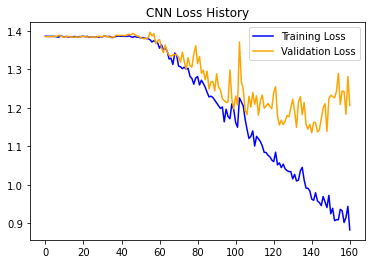

In [46]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'][1:], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'][1:], color='orange', label='Validation Loss')
plt.title('CNN Loss History')
plt.legend()
plt.savefig('CNN loss.png')


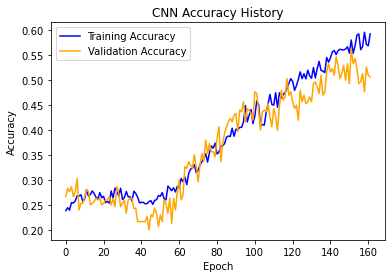

In [47]:
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy History')
plt.legend()
plt.savefig('CNN Accuracy.png')

In [48]:
_, acc = model.evaluate(validationX, validationY, verbose=0)
acc

0.5233333706855774

In [49]:
preds = model(validationX)
preds = np.argmax(preds,axis=1)

In [50]:
truth= np.argmax(validationY, axis=1)

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(truth, preds)
cm

array([[24, 16, 24, 16],
       [ 9, 35, 10, 11],
       [ 5,  3, 67,  7],
       [14, 12, 16, 31]])

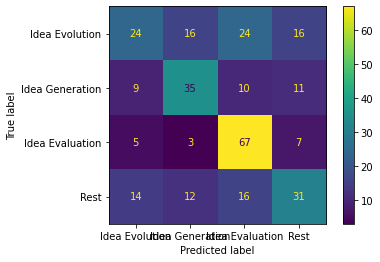

In [52]:
disp = ConfusionMatrixDisplay(cm, display_labels=['Idea Evolution', 'Idea Generation', 'Idea Evaluation', 'Rest'])
disp.plot()
plt.savefig('CNN Spectrogram Test Confusion Matrix')

## 1D Convolution

In [40]:
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', padding='same', input_shape=(217, 334, 3)))
model.add(MaxPooling2D(3))
model.add(Conv2D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
opt = Adam(learning_rate=.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 217, 334, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 72, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 111, 16)       2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 37, 16)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 14208)             0         
                                                                 
 dense_10 (Dense)            (None, 32)               

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0, horizontal_flip=True)
it_train = datagen.flow(trainX, trainY, batch_size=64)
steps = int(trainX.shape[0] / 64)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(validationX, validationY), callbacks=[callback, model_checkpoint_callback], verbose=1)

Epoch 1/200


2022-04-11 12:34:15.960986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 37.0590 - accuracy: 0.2557

2022-04-11 12:34:34.745038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 20s 563ms/step - loss: 37.0590 - accuracy: 0.2557 - val_loss: 1.3863 - val_accuracy: 0.2667
Epoch 2/200
33/33 [==============================] - 23s 700ms/step - loss: 1.4887 - accuracy: 0.2401 - val_loss: 1.3865 - val_accuracy: 0.2167
Epoch 3/200
33/33 [==============================] - 23s 688ms/step - loss: 1.3863 - accuracy: 0.2577 - val_loss: 1.3866 - val_accuracy: 0.2167
Epoch 4/200
33/33 [==============================] - 19s 581ms/step - loss: 1.3863 - accuracy: 0.2538 - val_loss: 1.3867 - val_accuracy: 0.2167
Epoch 5/200
33/33 [==============================] - 19s 567ms/step - loss: 1.3863 - accuracy: 0.2543 - val_loss: 1.3867 - val_accuracy: 0.2167
Epoch 6/200
33/33 [==============================] - 19s 558ms/step - loss: 1.3863 - accuracy: 0.2552 - val_loss: 1.3867 - val_accuracy: 0.2167
Epoch 7/200
33/33 [==============================] - 20s 597ms/step - loss: 1.3864 - accuracy: 0.2518 - val_loss: 1.3867 - val_accuracy: 0.2167
Epo

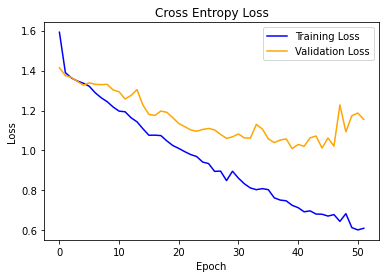

In [22]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'][1:], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'][1:], color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('CNN 1D Loss.png')


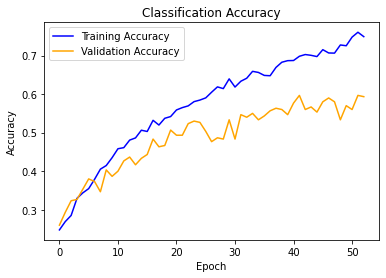

In [23]:
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('CNN 1D Accuracy.png')

In [24]:
_, acc = model.evaluate(validationX, validationY, verbose=0)
acc

0.5766666531562805

In [25]:
preds = model(validationX)
preds = np.argmax(preds,axis=1)

In [26]:
truth= np.argmax(validationY, axis=1)

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(truth, preds)
cm

array([[38,  9,  3, 25],
       [10, 44,  3,  6],
       [ 9, 12, 50,  6],
       [23, 16,  5, 41]])

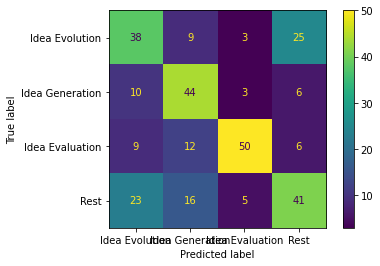

In [28]:
disp = ConfusionMatrixDisplay(cm, display_labels=['Idea Evolution', 'Idea Generation', 'Idea Evaluation', 'Rest'])
disp.plot()
plt.savefig('CNN Spectrogram Test Confusion Matrix')

In [147]:
import tensorflow as tf

preprocess_input = keras.applications.xception.preprocess_input


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=1):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [148]:
img_array = preprocess_input(get_img_array('temp.png', size=(217, 334, 3)))

heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_23')

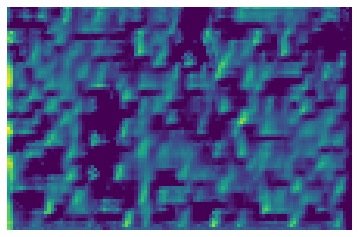

In [149]:
plt.matshow(heatmap)
plt.axis('off')
plt.savefig('Gradcam Idea Generation', bbox_inches='tight', pad_inches=0)

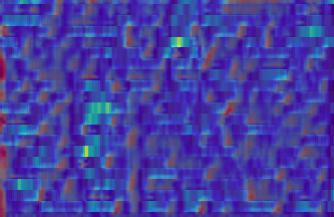

In [150]:
from IPython.display import Image, display
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.3):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam('temp.png', heatmap)

In [151]:
model(trainX[200:202])

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.9619059 , 0.02806025, 0.001262  , 0.00877188],
       [0.29113096, 0.2547555 , 0.22846968, 0.22564384]], dtype=float32)>

In [152]:
trainY[200:202]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

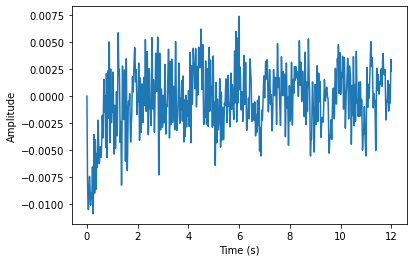

In [64]:
time = np.arange(dat[0].size) / 300
plt.plot(time, dat[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('signal.png')

(array([[[ 72,  29, 111],
         [ 72,  29, 111],
         [ 72,  28, 110],
         ...,
         [ 70,  11,  94],
         [ 70,  11,  94],
         [ 71,  13,  96]],
 
        [[ 72,  29, 111],
         [ 72,  29, 111],
         [ 72,  28, 110],
         ...,
         [ 70,  11,  94],
         [ 70,  11,  94],
         [ 71,  13,  96]],
 
        [[ 72,  29, 111],
         [ 72,  29, 111],
         [ 72,  28, 110],
         ...,
         [ 70,  11,  94],
         [ 70,  11,  94],
         [ 71,  13,  96]],
 
        ...,
 
        [[ 69,   5,  89],
         [ 69,   5,  89],
         [ 68,   2,  86],
         ...,
         [ 68,   1,  84],
         [ 68,   2,  86],
         [ 68,   1,  84]],
 
        [[ 69,   5,  89],
         [ 69,   5,  89],
         [ 68,   2,  86],
         ...,
         [ 68,   1,  84],
         [ 68,   2,  86],
         [ 68,   1,  84]],
 
        [[ 69,   5,  89],
         [ 69,   5,  89],
         [ 68,   2,  86],
         ...,
         [ 68,   1,  84],
  

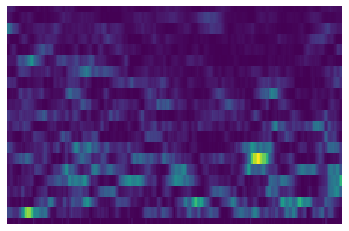

In [72]:
dat = np.array(data['1_idea generation'])[:, :3600]
generate_spectrogram(dat)

In [49]:
dat.size

3600